In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numpy as np
import json, hashlib





In [3]:
"""General Functions"""

from ising import run_multi_core, set_input
from glob import glob

def dict_to_string(dict):
    t_name=""
    for key, val in dict.items():
        t_name+=str(key)+":"+str(val)+" "
    return t_name


def run(params = {}):
    inp = set_input("")
    for key,value in params.items():
        inp[key]=value


    inpstring = dict_to_string(inp)

    run_multi_core(inp)

Tc=2.269


[ 2.30652917e+00  6.51895408e-05 -1.00004783e+00] [ 2.28503758e+00  3.81770108e-05 -1.00000604e+00]


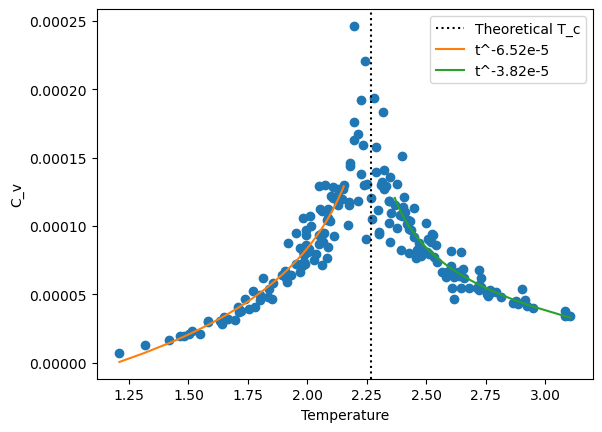

In [87]:
"""Calculate alpha"""


#SC,EM = getRun({"t_step":0.01, "flip_perc":0.1, "N":100, "t_min":1.2, "t_max":3.2, "n_burnin":60000, "n_steps":100000, "t_top":4, "B_top":1, "use_gaussian":True})
#run({"t_step":0.01, "flip_perc":0.1, "N":100, "t_min":1.2, "t_max":3.2, "n_burnin":60000, "n_steps":100000, "t_top":4, "B_top":1, "use_gaussian":False})

SC = pd.read_csv("data/1.20T3.20_SC_v0.csv", skiprows=[0,1,2])
EM = pd.read_csv("data/1.20T3.20_EM_v0.csv", skiprows=[0,1,2])

def spike(x,Tc,a,c):
    return np.abs((x-Tc)/Tc)**-a+c

T=EM["Temp"]
cv=1/T**2*(EM["E_std"]**2)#why is T squared? because beta=1/(kb*T)

plt.plot(T,cv,"o")
#plt.errorbar(T,cv,)
plt.axvline(2.269,color="k",linestyle=":", label="Theoretical T_c")


leftTop = np.where(T > Tc-0.1)[0][0]
rightBottom = np.where(T<Tc+0.1)[0][-1]

leftT=T[0:leftTop]
rightT=T[rightBottom:]

lpopt, lpcov = curve_fit(spike,leftT,cv[0:leftTop], p0=(2.26,0,0))
rpopt, rpcov = curve_fit(spike,rightT,cv[rightBottom:], p0=(2.26,0,0))

plt.plot(leftT,spike(leftT,*lpopt), label=f"t^-{round(lpopt[1]*1e5,2)}e-5")
plt.plot(rightT,spike(rightT,*rpopt), label=f"t^-{round(rpopt[1]*1e5,2)}e-5")


print(lpopt,rpopt)

plt.xlabel("Temperature")
plt.ylabel("C_v")
plt.legend()
#popt,pcov = curve_fit(spike,T,cv, p0=(2.26,0,0))
#plt.plot(T,spike(T,*popt))
#print(popt)


[2.27964211 0.33219774 1.93416331]


/var/folders/rl/cpjcq0556r36l75xt982r2kh0000gn/T/ipykernel_2762/2104031462.py:30: RuntimeWarning: invalid value encountered in power
  return (1-np.sinh(2/(T*Tc+Tc))**-4)**0.125


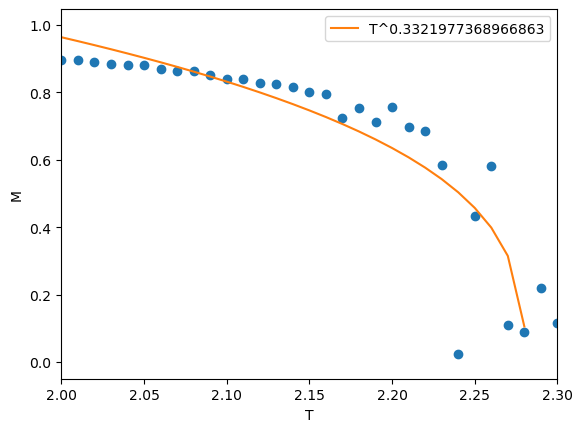

In [72]:
"""Calculate beta"""

#SC,EM = getRun({"t_step":0.01, "flip_perc":0.05, "N":40, "t_min":1.6, "t_max":2.3, "n_burnin":75000, "n_steps":100000, "b_top":10, "t_top":20, "use_gaussian":False})

M=abs(EM["M_mean"])
T=EM["Temp"]
plt.plot(T,M,"o")

def sloop(t,Tc,beta,b):
    return b*np.abs((t-Tc)/Tc)**beta
#def line(x,m,b):
#    return x*m+b

iMin = np.where(T > 2)[0][0]
iMax = np.where(T<2.3)[0][-1]

popt,pcov = curve_fit(sloop,T[iMin:iMax],M[iMin:iMax],p0=(2.265,1/8,1), maxfev=5000)
#popt,pcov = curve_fit(line,T[iMin:iMax],M[iMin:iMax])
print(popt)

plt.plot(T[iMin:iMax],sloop(T[iMin:iMax],*popt),label=f"T^{popt[1]}")
plt.xlabel("T")
plt.ylabel("M")
plt.legend()
plt.xlim(2,2.3)
#plt.yscale("log")
#plt.xscale("log")

def analyticalM(T):
    return (1-np.sinh(2/(T*Tc+Tc))**-4)**0.125

plt.plot(np.linspace(np.min(T),0,100),analyticalM(np.linspace(np.min(T),0,100)))



[2.26000000e+00 1.75000000e+00 4.66296747e-31 3.31117494e-04] [ 2.26000000e+00  1.75000000e+00 -7.72961687e-32  8.26668290e-04]


/Users/gfitez/anaconda3/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


(2.0, 3.0)

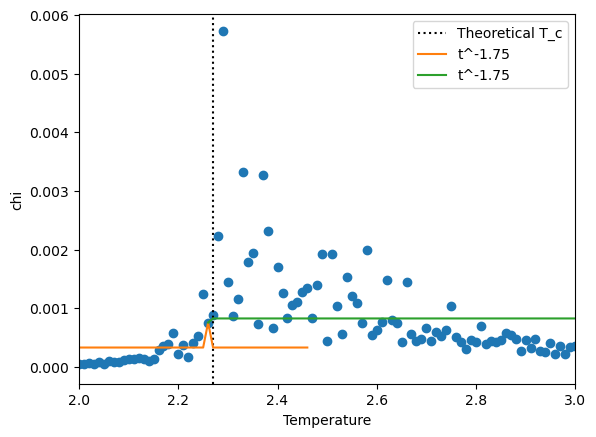

In [73]:
"""Calculate gamma"""
#use the other way to get gamma


#SC,EM = getRun({"t_step":0.05, "flip_perc":0.2, "N":30, "t_min":1.2, "t_max":3.2, "n_burnin":25000, "n_steps":50000, "t_top":4, "use_gaussian":False})

def chiSpike(x,Tc,a,c,d):
    #Tc=2.269
    return c*np.abs((x-Tc)/Tc)**-a+d

T=EM["Temp"]
M=EM["M_mean"]

chi=1/T*EM["M_std"]**2

plt.plot(T,chi,"o")
plt.axvline(2.269,color="k",linestyle=":", label="Theoretical T_c")


leftTop = np.where(T > Tc+0.2)[0][0]
rightBottom = np.where(T<Tc)[0][-1]

leftT=T[0:leftTop]
rightT=T[rightBottom:]



lpopt, lpcov = curve_fit(chiSpike,leftT,chi[0:leftTop], p0=(2.26,7/4,0,0), maxfev=50000)
rpopt, rpcov = curve_fit(chiSpike,rightT,chi[rightBottom:], p0=(2.26,7/4,0,0), maxfev=50000)

plt.plot(leftT[0:leftTop],chiSpike(leftT[0:leftTop],*lpopt), label=f"t^-{round(lpopt[1],5)}")
plt.plot(rightT,chiSpike(rightT,*rpopt), label=f"t^-{round(rpopt[1],5)}")
print(lpopt,rpopt)

plt.xlabel("Temperature")
plt.ylabel("chi")
plt.legend()
plt.xlim(2,3)


input hash: 87ed26d2ab26aad70999a78ecd1e0e53
Using cached run
Using cached run
input hash: e2293f10f8f0f75b54b898c6b854754e
Using cached run
Using cached run
input hash: 0828208901ed4e2b6202fc462dde1415
Using cached run
Using cached run
input hash: 4fbc429b2b963a0f3b7e12566bcb81a7
Using cached run
Using cached run
input hash: 06670f626d2cc0a824d4e4228841a8c6
Using cached run
Using cached run
input hash: 1290abfcc20fca3c70c0c37cd40ec4f7
Using cached run
Using cached run
input hash: 5f07d35eed1ec1fa103a8fecc2111da3
Using cached run
Using cached run
input hash: 6805830e24ff489991f0d30e0e9fe35c
Using cached run
Using cached run
input hash: c84128f16580be72d411a1c2b2642c4a
Using cached run
Using cached run
input hash: 2ea65d87a7bd84666a89262f41a1c7d0
Using cached run
Using cached run
input hash: e6b7c0d40a1514d24ef672a90c8c1229
Using cached run
Using cached run
input hash: 4b24a8477bd328810dcdddd36c51d78f
Using cached run
Using cached run
input hash: 5a4835e027ecd98952eb20eb99c205c4
Using c

Text(0, 0.5, 'M')

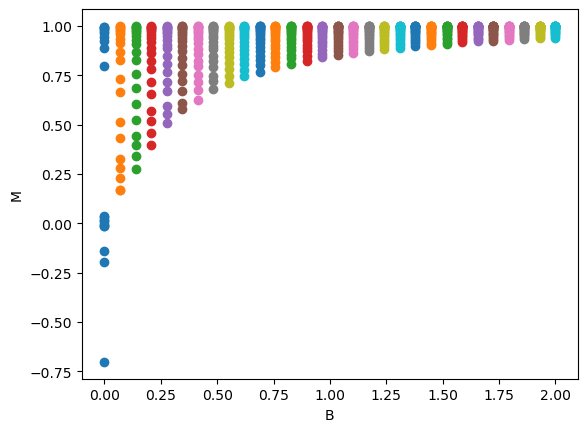

In [17]:
"""Calculate delta (I realized we actually don't have to do this)"""

Bs=np.linspace(0,2,30)
EMs=[]
for B in Bs:
    SC,EM = getRun({"t_step":0.1, "flip_perc":0.2, "N":30, "t_min":1.2, "t_max":3.2, "n_burnin":25000, "n_steps":50000, "t_top":4, "B":B ,"use_gaussian":False})
    EMs.append(EM)

for EM,B in zip(EMs,Bs):
    M=EM["M_mean"]
    plt.plot([B]*len(M),M,"o")

plt.xlabel("B")
plt.ylabel("M")



[ 0.2428177  -0.00647514  0.01217461]
[ 0.18662672 -0.00787496  0.0131227 ]
[ 0.23568157 -0.00567047  0.01112069]
[ 0.19052553 -0.00678873  0.01177325]
[ 0.15612884 -0.01132381  0.01652162]
[ 0.39806086 -0.00274375  0.00778692]
[ 0.21617007 -0.00776175  0.01278463]
[ 0.14893099 -0.01218991  0.01747608]
[ 0.50267593 -0.00134572  0.00655853]
[ 0.33871702 -0.00383185  0.00899399]


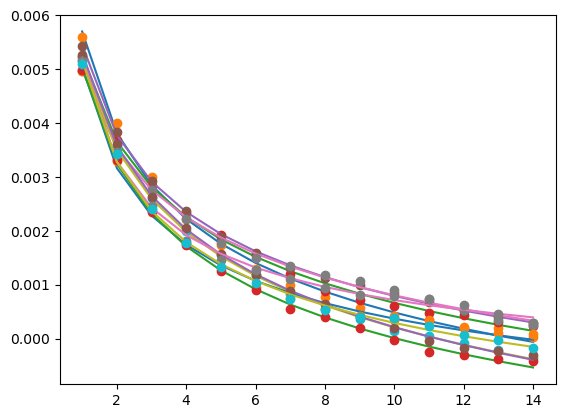

0.26163352403772266


In [74]:
"""Calculate eta"""
#SC,EM = getRun({"t_step":0.01, "flip_perc":0.05, "N":100, "t_min":2.3, "t_max":2.7, "n_burnin":25000, "n_steps":50000, "b_top":10, "t_top":20, "use_gaussian":False})

def correlationFalloff(x,eta,c,a):
    return a*np.abs(x)**(-eta)+c


temps=[]
x=0
count=0
for i in range(SC.shape[0]):
    row = SC.iloc[i]
    temps.append(row[0])

    if temps[-1] >2.3 and temps[-1]<2.4:

        correlations=row[1:15]
        xVals=np.arange(1,len(correlations)+1)

        popt,pcov = curve_fit(correlationFalloff, xVals, correlations, maxfev=5000)

        plt.plot(xVals, correlationFalloff(xVals, *popt))
        plt.plot(xVals, correlations,"o")
        print(popt)
        x+=popt[0]
        count+=1

    #xis.append(popt[0])
plt.show()
print(x/count)



[3.08547952e+00 1.20732451e-03 5.66370591e-03]
[ 2.76050911e+00 -1.79313178e-04  5.68215464e-03]
[2.96513728e+00 5.70580646e-04 6.00385804e-03]
[3.57322659e+00 3.62558787e-04 6.20859205e-03]
[ 3.73067331e+00 -5.63193939e-04  6.51755376e-03]
[3.18428406e+00 4.95816755e-04 6.08919479e-03]
[3.28840377e+00 4.25691448e-04 6.30826210e-03]
[3.25849396e+00 1.18872350e-03 6.14597219e-03]
[2.75078968e+00 6.06246340e-04 6.31390857e-03]
[2.86935672e+00 2.53134584e-04 6.83703150e-03]
[ 3.39351841e+00 -1.47298113e-05  6.93587549e-03]
[3.00008886e+00 3.80399948e-05 7.13337754e-03]
[ 3.18525534e+00 -1.27166484e-04  7.14424538e-03]
[2.67787665e+00 6.24250954e-05 7.13904099e-03]
[3.39008733e+00 3.79747356e-04 6.50202252e-03]
[2.92766492e+00 3.68344575e-06 6.36647787e-03]
[ 3.05699288e+00 -1.84177652e-04  7.04914305e-03]
[ 2.77612520e+00 -7.14181920e-05  7.08372844e-03]
[2.72323825e+00 1.15926913e-04 6.82178676e-03]
[ 2.52493255e+00 -1.57155767e-04  7.30903285e-03]
[ 3.63631583e+00 -5.21032585e-04  7.112

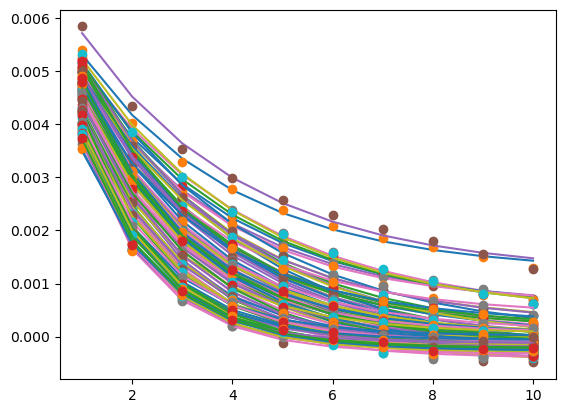

[ 2.6         0.52224152  3.73750778 -4.61287263]


/Users/gfitez/anaconda3/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


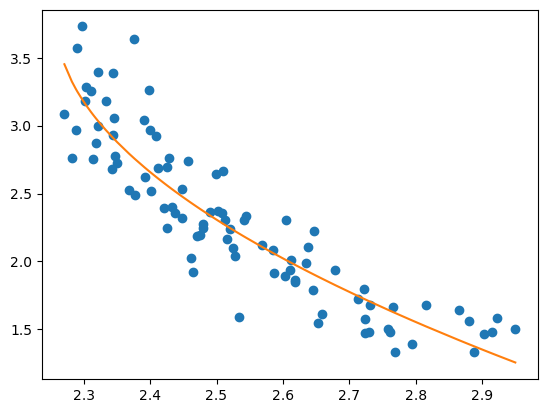

In [88]:
"""Calculate nu"""
#SC,EM = getRun({"t_step":0.01, "flip_perc":0.05, "N":100, "t_min":2.3, "t_max":2.7, "n_burnin":25000, "n_steps":50000, "b_top":10, "t_top":20, "use_gaussian":False})


correlations=[]
temps=[]

def correlationFalloff(d,xi,c,a):
    return a*np.exp(-d/xi)+c


xis=[]
for i in range(SC.shape[0]):
    row = SC.iloc[i]
    temp=row[0]

    if temp>Tc and temp<3:
        temps.append(temp)

        correlations=row[1:11]
        xVals=np.arange(1,len(correlations)+1)

        popt,pcov = curve_fit(correlationFalloff, xVals, correlations, maxfev=20000)
        print(popt)
        plt.plot(xVals, correlationFalloff(xVals, *popt))
        plt.plot(xVals, correlations,"o")

        xis.append(popt[0])
plt.show()


plt.plot(temps,xis,"o")

def correlationVTemp(t,Tc,nu,c,a):
    Tc=2.26
    return a*abs((t-Tc)/Tc)**nu+c

popt,pcov = curve_fit(correlationVTemp, temps, xis, maxfev=50000, p0=(2.6,1,0,1))


plt.plot(temps,correlationVTemp(np.array(temps), *popt))
print(popt)

